# Compositional Nutrient Diagnosis

Compositional Nutrient Diagnosis (CND) is the multivariate expansion of CVA and DRIS
and is fully compatible with PCA. CND nutrient indices
are composed of two separate functions, one considering differences between nutrient levels, another examining
differences between nutrient balances (as defined by nutrient geometric means), of individual and target specimens.
These functions indicate that nutrient insufficiency can be corrected by either adding a single nutrient or taking
advantage of multiple nutrient interactions to improve nutrient balance as a whole.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize

## Input concentrations of the nutrients

In [2]:
data_diagnosed_dict = {
    'P': [12,11,10, 9],
    'Mg': [2,2,3,3],
    'N': [1,2,1,2],
    'Ca': [3,4,3,3],
    'Mn': [4,5,4,2]
}

data_optimum_dict = {
    'p': [12,11,10],
    'mg': [2,1,3],
    'n': [2,1,1],
    'ca': [4,4,3],
    'mn': [5,4,4],
}

df_diagnosed = pd.DataFrame(data_diagnosed_dict)
df_optimum = pd.DataFrame(data_optimum_dict)

## The z-values $z_i$

The z-values are defined as $z_i = \log(x_i/g(x))$

- $g(x)$ is the geometric mean

In [3]:
def calculate_z(df):
    ''' Calculates z for CND analysis on a DataFrame input.
      Args:
        df (pd.DataFrame): DataFrame with columns representing nutrient concentrations for each plant.
      Returns:
        pd.DataFrame: DataFrame containing z values with column names prefixed by "z_".
    '''
    # Normalize each row so that the sum of nutrients is 1
    row_sums = df.sum(axis=1)
    x = df.div(row_sums, axis=0)

    # Calculate the geometric mean for each row
    g = x.prod(axis=1)**(1/x.shape[1])

    # Compute z values
    z = np.log(x.div(g, axis=0))

    # Rename columns to reflect that they are z values
    z.columns = [f'z_{col}' for col in df.columns]

    return z

z_population = calculate_z(df_diagnosed)
z_population.head()
# add some statistics and show the distribution of the concentration and the z values

,z_P,z_Mg,z_N,z_Ca,z_Mn
0,1.352315,-0.439445,-1.132592,-0.033980,0.253702
1,1.041911,-0.662837,-0.662837,0.030310,0.253454
2,1.125364,-0.078609,-1.177221,-0.078609,0.209074
3,1.041076,-0.057536,-0.463002,-0.057536,-0.463002


## The CND index $I_{z_i}$

The CND index is given by $I_{z_i}=(Z_i - z_i) / \sigma_{z_i}$
- $Z_i$ is the z-value of the **test** population for nutrient $i$
- $z_i$ is the z-value of the **target** population for nutrient $i$
- $\sigma_{z_i}$ is the standard deviation of the z-value of the **target** population for nutrient $i$


This index $I_{z_i}$ is the differenz of the z-values normalized by the standart deviation of the target population.
Therefore, for each nutrient, $I_{z_i}$ measures the distance between the test and target population.

The normalization with $\sigma_{z_i}$ is to have a sensible scale. If a nutrient of the target population has a large standard deviation it means that the range of 'acceptable' nutrient amount is large. As a result the $I_{z_i}$ for this nutrient is scaled down (smaller) for this nutrient.

The interpretation of the the index $I_{z_i}$:
- $I_{z_i} < 0$: relative nutrient insufficiency
- $I_{z_i} = 0$: relative nutrient balance
- $I_{z_i} > 0$: relative nutrient excess


We can deepen the dicussion of $I_{z_i}$ by writing it as a sum and analysing each term:

$I_{z_i} = \frac{1}{\sigma_{z_i}} \biggl[\underbrace{\log\left( \frac{X_i}{x_i} \right)}_{ f(X_i)} + \underbrace{ \log\left( \frac{g(X_i)}{g(x_i)} \right)}_{ f(g(X_i))} \biggr]$

- The first term $f(X_i) = \log\left( \frac{X_i}{x_i} \right)$ is only dependent on the **individual** nutrient
- The second term $f(X_i) = \log\left( \frac{g(X_i)}{g(x_i)} \right)$ is only dependent on the geometric means $g$ therefore takes into acount **every** nutrient

In [4]:
def calculate_I(df_diagnosed, df_optimum):
    ''' 
    Calculates I for CND analysis using DataFrame inputs, based on the mean z values.
      Args:
        df_diagnosed (pd.DataFrame): DataFrame with nutrient concentrations of the diagnosed population.
        df_optimum (pd.DataFrame): DataFrame with nutrient concentrations of the optimum (target) population.
      Returns:
        pd.DataFrame: DataFrame containing I values with column names prefixed by "I_".
    '''
    # Calculate z values for diagnosed and optimum using the calculate_z function
    z_diagnosed = calculate_z(df_diagnosed)
    z_optimum = calculate_z(df_optimum)

    # Calculate mean z values for each nutrient
    mean_z_diagnosed = z_diagnosed.mean(axis=0)
    mean_z_optimum = z_optimum.mean(axis=0)

    # Calculate standard deviations for each nutrient across optimum rows
    stds = z_optimum.std(axis=0)

    # Calculate I values for each nutrient using the mean z values
    I_values = (mean_z_diagnosed.values - mean_z_optimum.values) / stds.values

    # Convert the I values to a DataFrame and rename columns to reflect they are I values
    I_values_df = pd.DataFrame([I_values], columns=[f'I_{col}' for col in df_diagnosed.columns])

    return I_values_df

Is = calculate_I(df_diagnosed, df_optimum)

Is.head()

,I_P,I_Mg,I_N,I_Ca,I_Mn
0,-0.423486,0.596274,0.410194,-0.574762,-2.662266


## Visualization of the I index

<Axes: >

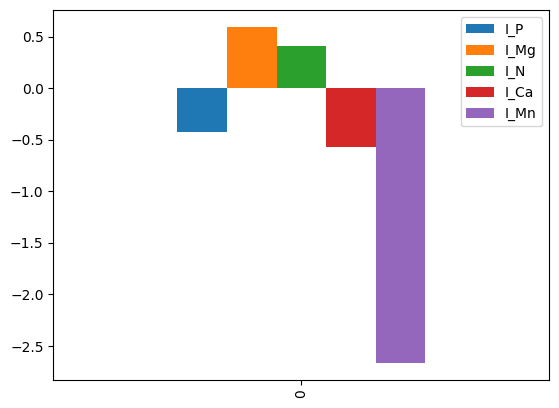

In [6]:
def plot_bar_for_each_row(data):
    # Ensure the input is a DataFrame
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input must be a Pandas DataFrame")
    
    # Replace NaN or Inf values with 0 for plotting purposes
    data = data.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    num_rows, num_cols = data.shape
    column_names = data.columns

    # Adjust grid size based on data
    rows = (num_rows // num_cols) + (1 if num_rows % num_cols else 0)
    
    # Create subplots with a grid layout
    fig, axes = plt.subplots(rows, num_cols, figsize=(16, 8))
    axes = np.atleast_1d(axes).flatten()
    
    # Determine y-axis limits
    y_min = data.min().min()
    y_max = data.max().max()
    y_shift = 1

    # Plot each row as a separate bar plot
    for i, (index, row) in enumerate(data.iterrows()):
        axes[i].bar(column_names, row)
        axes[i].set_title(f'Plant {index + 1}')
        axes[i].set_xlabel('Nutrient')
        axes[i].set_ylabel('$I_z$')
        axes[i].set_ylim([y_min - y_shift, y_max + y_shift])

    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

Is.plot.bar()



In [537]:
std_nutrient = np.std(Is, axis=0)
variance_nutrient = np.var(Is, axis=0)

Interesing plots could be:

1. Distribution of Is per nutrient
2. Varience per nutrient as barplot
3. 

Text(0.5, 1.0, 'Standard deviation per nutrient')

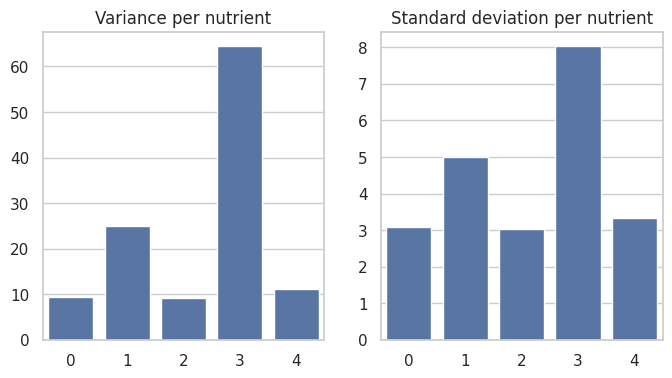

In [538]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.barplot(data=variance_nutrient, ax=ax[0])
ax[0].set_title('Variance per nutrient')
sns.barplot(data=std_nutrient, ax=ax[1])
ax[1].set_title('Standard deviation per nutrient')

## Optimizing relative fertilizer mixture

In the following we optimize the relative amount of fertilizer to get the minimal relative nutrient deficiency/excess based on the I-index.
Note, that the I value does not report about absolute concentration of nutrients. Therefore we can only obtain the relative amount.
The absolute amount of the fertilizer mixture can be obtained from a subsequent optimization, where the difference of absolute nutrient concentrations is optimized.

In [539]:
"""
In the following only a  the fertilizer mixture for plant 1 is optimized. 
This step has to be repeated for each plant.
"""

def objective_function(params, c_population, c_fertilizer1, c_fertilizer2, c_target):
    a, b = params
    # Calculate the value to be minimized
    value = np.sum(np.abs(calculate_I(
        c_population=(c_population[0, :] + a * c_fertilizer1 + b * c_fertilizer2),
        c_target=c_target[0, :]
    )))
    return value  # We want to minimize this value

def optimize_a_b(c_population, c_fertilizer1, c_fertilizer2, c_target):
    # Initial guess for a and b
    initial_guess = [0, 0]
    bounds = [(0, None), (0, None)]  # (lower bound, upper bound) for a and b
    
    # Call the optimizer
    result = minimize(objective_function, initial_guess, 
                      args=(c_population, c_fertilizer1, c_fertilizer2, c_target),
                      bounds = bounds,  # (lower bound, upper bound) for a and b
                      method='L-BFGS-B')  # BFGS is a commonly used optimization method
    
    # Extract the optimized values of a and b
    a_opt, b_opt = result.x
    return a_opt, b_opt, result.fun  # Return optimized a, b, and the minimized value


In [540]:
c_fertilizer1 = np.abs(np.random.sample(5))
c_fertilizer2 = np.abs(np.random.sample(5))
a_opt, b_opt, minimized_value = optimize_a_b(c_population, c_fertilizer1, c_fertilizer2, c_target)

print(f"{minimized_value=}")
value = calculate_I(c_population=(c_population[0,:]+a_opt*c_fertilizer1+b_opt*c_fertilizer2),c_target=c_target[0,:])
print(f"{[a_opt, b_opt]=}")
print(f"{value=}")
print(f"{np.abs(value)=}")
print(f"{np.sum(np.abs(value))=}")

minimized_value=5.974567690656485
[a_opt, b_opt]=[4.2128625386594685, 0.0]
value=array([ 5.38862642e-10, -2.07709548e+00, -5.61614850e-01,  2.98728384e+00,
       -3.48573512e-01])
np.abs(value)=array([5.38862642e-10, 2.07709548e+00, 5.61614850e-01, 2.98728384e+00,
       3.48573512e-01])
np.sum(np.abs(value))=5.974567690656485


### Constraint optimization

In [541]:
"""
Currently not converging 
"""


# Define the objective function (optional, can just return 0 since we only care about constraints)
def objective_function(params, c_population, c_fertilizer1, c_fertilizer2, c_target):
    # The objective can be something to minimize, like sum of absolute differences.
    # However, in this case, we primarily care about constraints.
    return 0  # We don't need to minimize anything, we just want the values to be within the range

# Define the constraint function (ensures values are within the specified range)
def constraint_function(params, c_population, c_fertilizer1, c_fertilizer2, c_target, lower_bounds, upper_bounds):
    a, b = params
    # Compute the values from calculate_I
    values = calculate_I(
        c_population=(c_population[0, :] + a * c_fertilizer1 + b * c_fertilizer2),
        c_target=c_target[0, :]
    )
    
    # Create constraint inequalities: lower_bounds <= values <= upper_bounds
    return np.concatenate([values - lower_bounds, upper_bounds - values])

def optimize_a_b_with_constraints(c_population, c_fertilizer1, c_fertilizer2, c_target, lower_bounds, upper_bounds):
    # Initial guess for a and b
    initial_guess = [0, 0]
    
    # Define the bounds as constraints for scipy minimize
    constraints = {
        'type': 'ineq',  # Inequality: ensures values are within bounds
        'fun': constraint_function,
        'args': (c_population, c_fertilizer1, c_fertilizer2, c_target, lower_bounds, upper_bounds)
    }
    
    # Call the optimizer
    result = minimize(objective_function, initial_guess, 
                      args=(c_population, c_fertilizer1, c_fertilizer2, c_target),
                      constraints=constraints, method='SLSQP')  # SLSQP supports constrained optimization
    
    # Extract the optimized values of a and b
    if result.success:
        a_opt, b_opt = result.x
        return a_opt, b_opt, result.fun  # Return optimized a, b, and minimized value (if applicable)
    else:
        print("Optimization failed:", result.message)
        return None, None, None  # Return None if the optimization fails

# Example usage (replace these with actual values):
lower_bounds = np.array([0.1, 0.2, 0.3, 0.4, 1])  # Example lower bounds for each of the 4 values
upper_bounds = np.array([1.0, 1.5, 2.0, 2.5, 2])  # Example upper bounds for each of the 4 values

a_opt, b_opt, minimized_value = optimize_a_b_with_constraints(c_population, c_fertilizer1, c_fertilizer2, c_target, lower_bounds, upper_bounds)


Optimization failed: Positive directional derivative for linesearch


In [542]:
# value = calculate_I(c_population=(c_population[0,:]+a_opt*c_fertilizer1+b_opt*c_fertilizer2),c_target=c_target[0,:])
# print(f"{value=}")
# print(f"{np.sum(np.abs(value))=}")

## Optimizing the absolute amount of fertilizer

In the followin we optimize the amount we have to add of this fertilizer mixture.